In [71]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [72]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'])


In [73]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [74]:
sales_a = sales_a.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_a.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,54555,2738080,177316
1,2019-02-01,54293,4637013,300290
2,2019-03-01,58798,7079920,458491
3,2019-04-01,53229,3744057,242463
4,2019-05-01,50558,4196578,271768


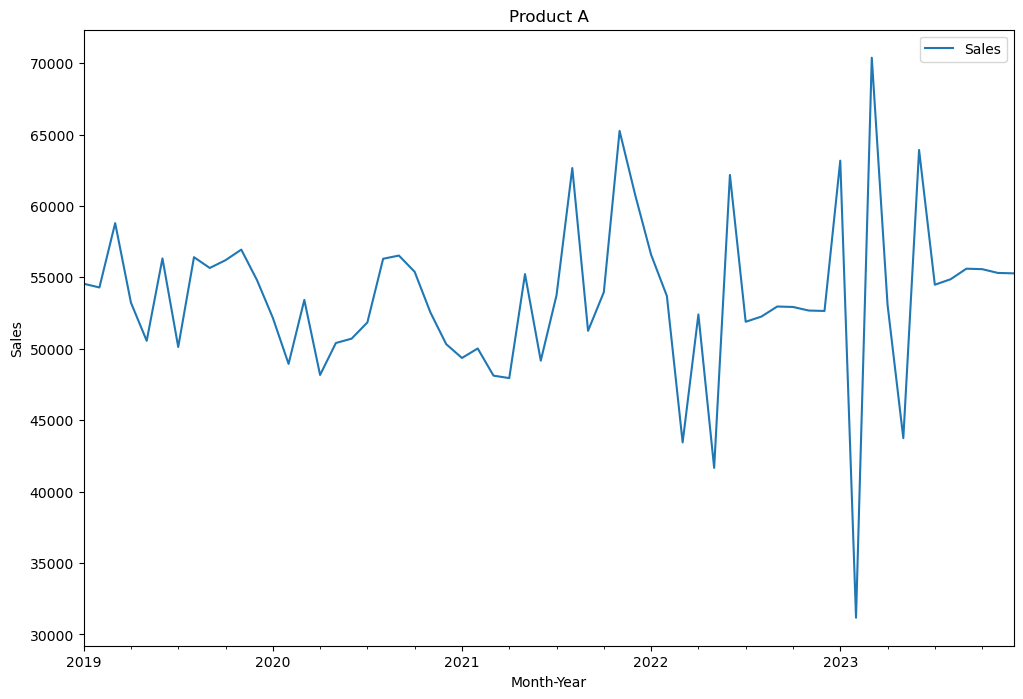

In [75]:
ax = sales_a.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product A')
plt.legend(['Sales'])
plt.show()


In [76]:
train= sales_a[:57]
test=sales_a[57:]

In [77]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:10:46 - cmdstanpy - INFO - Chain [1] start processing
21:10:46 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:51 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:02 - cmdstanpy - INFO - Chain [1] done processing
21:11:07 - cmdstanpy - INFO - Chain [1] start processing
21:11:07 - cmdstanpy - INFO - Chain [1] done processing
21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
21:11:18 - cmdstanpy - INFO - Chain [1] start processing
21:11:18 - cmdstanpy - INFO - Chain [1] done processing
21:11:24 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:28 - cmdstanpy - INFO - Chain [1] start processing
21:11:29 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   10006.328895  
1   10038.957175  
2    9930.788630  
3    9885.673573  
4    9914.438954  
..       

In [78]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
23,0.01,10.00,multiplicative,9780.591855
19,0.01,3.00,multiplicative,9781.203894
21,0.01,5.00,multiplicative,9786.987926
17,0.01,1.00,multiplicative,9804.354700
22,0.01,10.00,additive,9817.068431
...,...,...,...,...
66,0.50,3.00,additive,11364.807553
61,0.50,0.01,multiplicative,11482.641351
60,0.50,0.01,additive,11503.687136
70,0.50,10.00,additive,11759.820929


In [79]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


In [80]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.01, seasonality_prior_scale=10.0,seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [81]:
model.fit(train)

21:18:18 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [83]:
future_dates['Market Size'] = sales_a['Market Size']
future_dates['Marketing Expense'] = sales_a['Marketing Expense']

In [84]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,2738080,177316
1,2019-02-01,4637013,300290
2,2019-03-01,7079920,458491
3,2019-04-01,3744057,242463
4,2019-05-01,4196578,271768
5,2019-06-01,6396559,414237
6,2019-07-01,2545212,164826
7,2019-08-01,6294066,407600
8,2019-09-01,5454980,353261
9,2019-10-01,4923556,318846


In [85]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [86]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [87]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,56560.727643,47316.724162,64523.215937
58,2023-11-01,61149.534653,52737.778900,69791.695617
59,2023-12-01,54221.790519,45245.159520,62527.720544


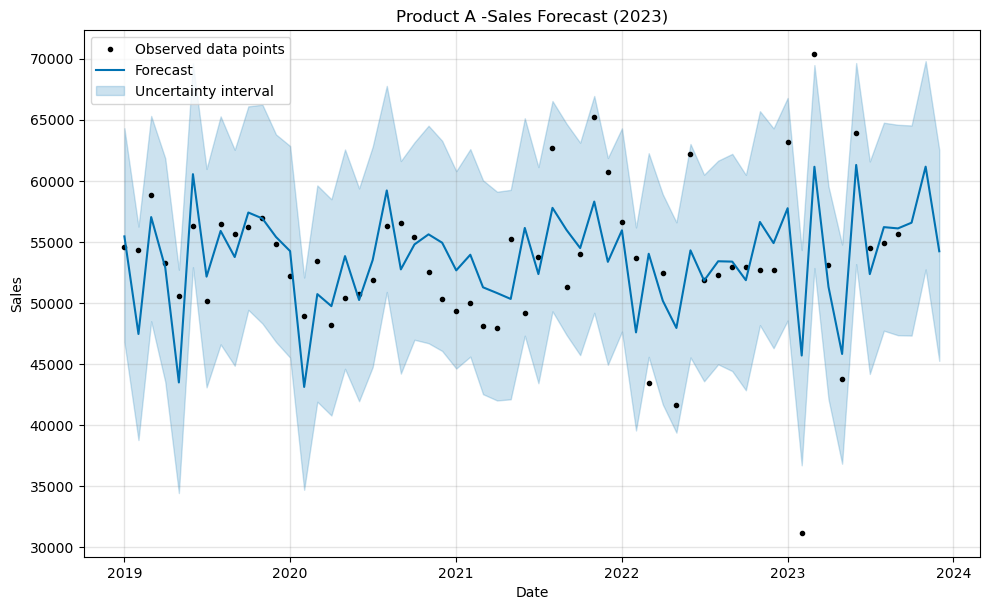

In [88]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product A -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

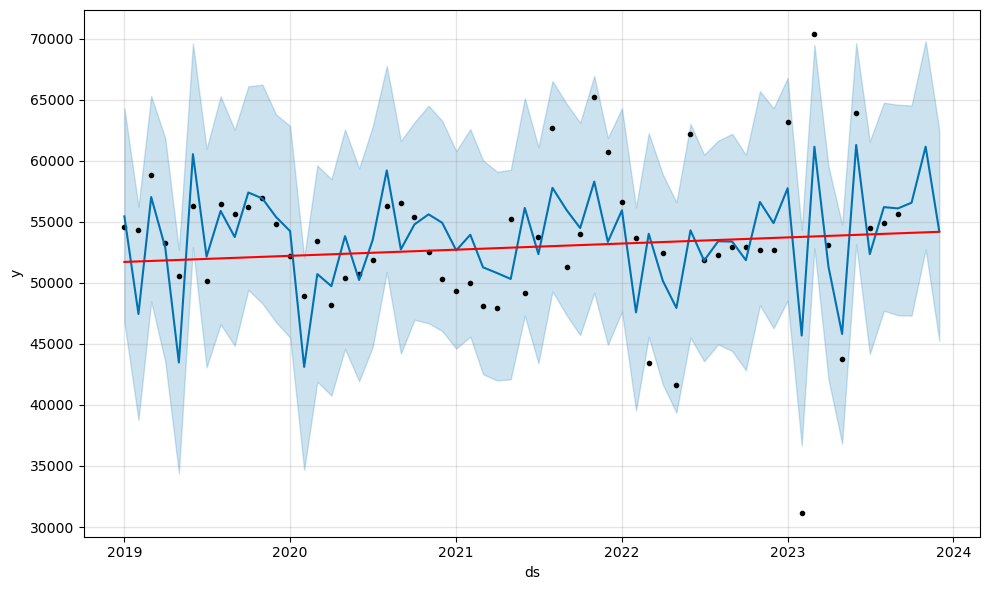

In [89]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

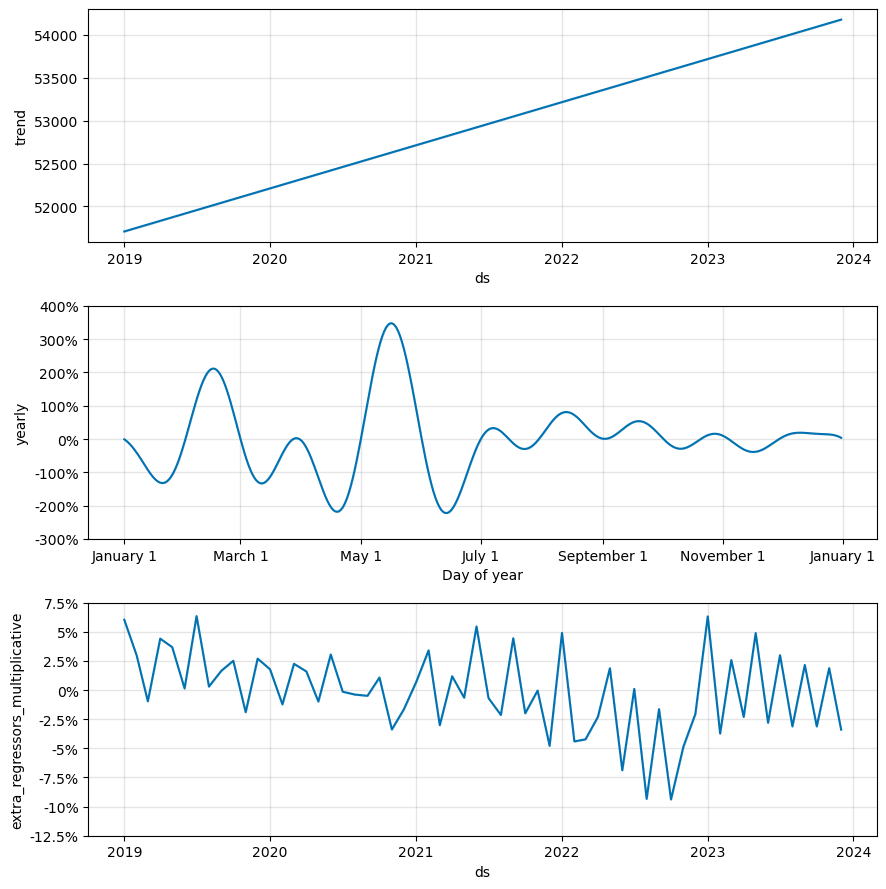

In [90]:
fig2 = model.plot_components(forecast)

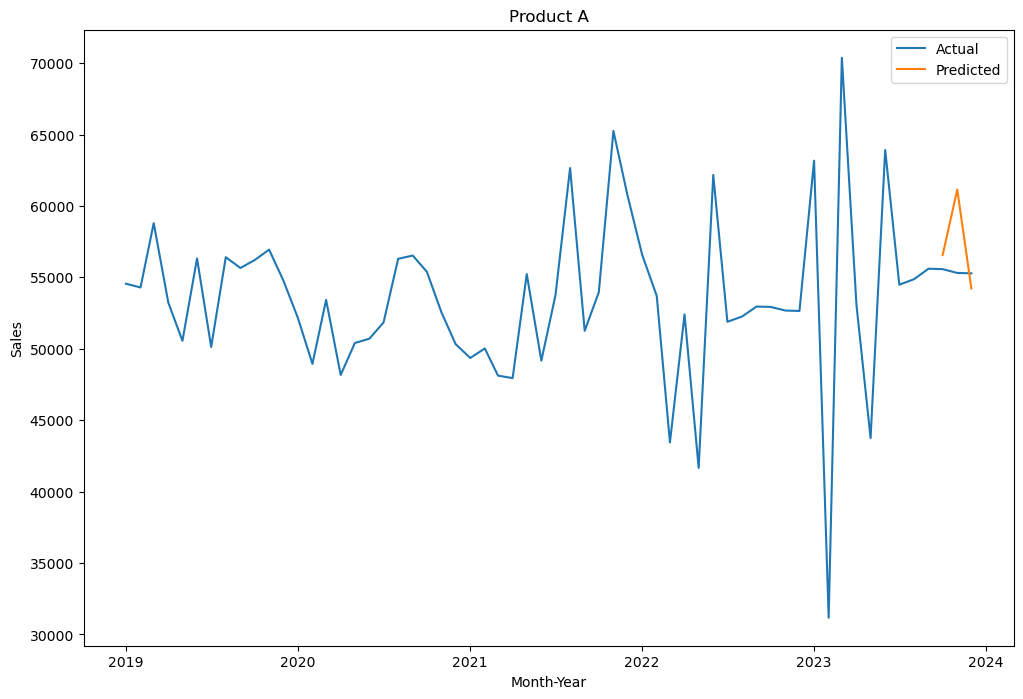

In [91]:
# Reset index of sales_b DataFrame
sales_a_reset_index = sales_a.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_a_reset_index['ds'], sales_a_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product A')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [92]:
#model evaluation

In [93]:
pred=forecasted_df['yhat']
test_df=test['y']

In [94]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 2627.824
MAPE - FB PROPHET: 0.047
MSE - FB PROPHET: 12060690.201
RMSE - FB PROPHET: 3472.850


In [95]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='365 days', horizon='365 days', parallel="processes")

In [96]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,8.222834e+06,2867.548415,2697.996841,0.050663,0.050663,0.049250,1.0
1,61 days,1.063370e+08,10311.981962,9366.720337,0.152785,0.152785,0.162862,0.5
2,91 days,3.199727e+07,5656.612842,4928.917608,0.083886,0.083886,0.087773,0.5
3,122 days,7.953323e+07,8918.140687,8888.368399,0.148221,0.148221,0.160095,0.0
4,153 days,3.268583e+08,18079.223028,13346.821438,0.420470,0.420470,0.301493,0.5
5,181 days,2.255965e+08,15019.869954,14089.094130,0.239322,0.239322,0.251610,0.0
6,212 days,9.035135e+06,3005.850048,2935.027890,0.055574,0.055574,0.054958,1.0
7,242 days,3.217478e+07,5672.282097,5404.285780,0.127626,0.127626,0.119185,0.5
8,273 days,3.396592e+07,5828.028761,4927.838264,0.078862,0.078862,0.083536,0.5
9,303 days,1.886038e+06,1373.331038,1366.952044,0.025777,0.025777,0.026118,1.0


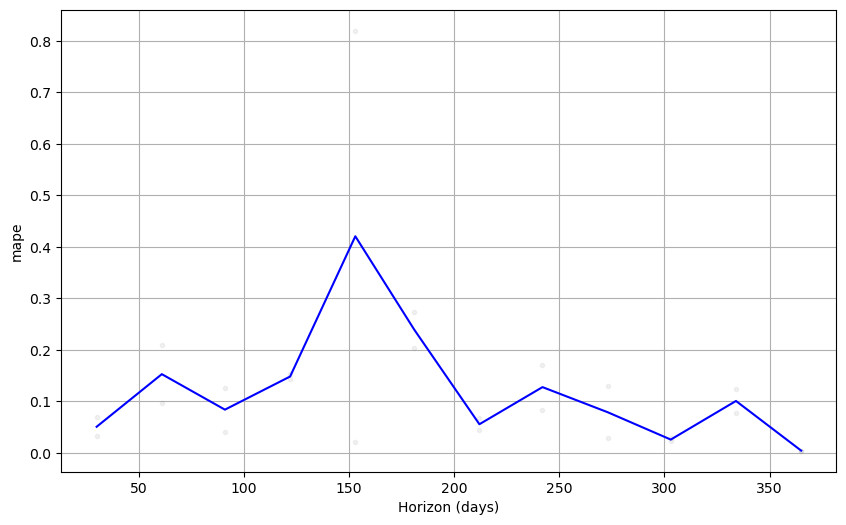

In [97]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [98]:
test_df

57    55575
58    55311
59    55281
Name: y, dtype: int64

In [99]:
pred

57    56560.727643
58    61149.534653
59    54221.790519
Name: yhat, dtype: float64